In [ ]:
# The model and dataloader related functions are sourced from:
# https://github.com/shailensobhee/medical-decathlon

# The Medical Decathlon dataset is sourced from:
# http://medicaldecathlon.com/

# Please refer to the original repositories for further information and attributions.

In [ ]:
import sys
import platform
import os

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Linux-6.1.58+-x86_64-with-glibc2.35


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "Med-Seg-Decathlon/Task02_Heart/"

crop_dim = 128
batch_size = 16
seed = 816
train_test_split = 0.85

In [ ]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_train = DatasetGenerator(trainFiles,
                            batch_size=batch_size,
                            crop_dim=[crop_dim, crop_dim],
                            augment=True, seed=seed)

ds_validation = DatasetGenerator(validateFiles,
                                 batch_size=batch_size,
                                 crop_dim=[crop_dim, crop_dim],
                                 augment=False,
                                 seed=seed)

ds_test = DatasetGenerator(testFiles,
                           batch_size=batch_size,
                           crop_dim=[crop_dim, crop_dim],
                           augment=False,
                           seed=seed)

******************************
Dataset name:         LeftAtrium
Dataset description:  Left atrium segmentation
Tensor image size:    3D
Dataset release:      1.0 04/05/2018
Dataset reference:    King’s College London
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 17
Number of validation files = 1
Number of testing files    = 2


(16, 128, 128, 1)


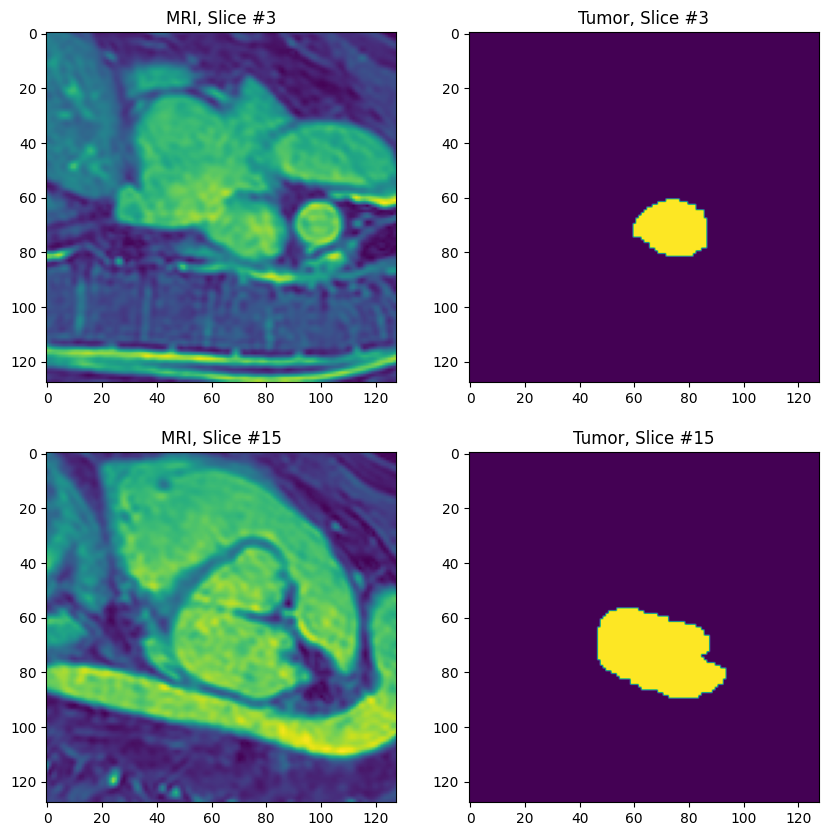

In [ ]:
ds_train.plot_samples()

(16, 128, 128, 1)


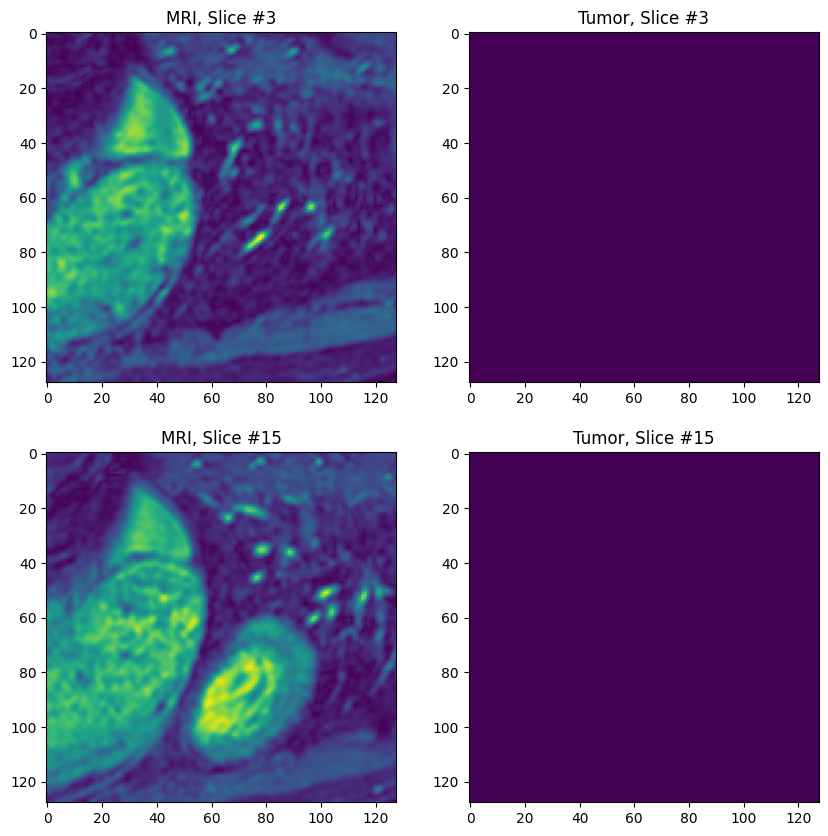

In [ ]:
ds_validation.plot_samples()

In [ ]:
from model import unet

print("-" * 30)
print("Creating and compiling model ...")
print("-" * 30)

unet_model = unet(fms=8, learning_rate=1e-3, use_dropout=False, use_upsampling=False, output_path="unet/output/", inference_filename="heart")

model = unet_model.create_model(
        ds_train.get_input_shape(),
        ds_train.get_output_shape())

model_filename, model_callbacks = unet_model.get_callbacks()

# # If there is a current saved file, then load weights and start from there.
# saved_model = os.path.join(args.output_path, args.inference_filename)
# if os.path.isfile(saved_model):
#     model.load_weights(saved_model)

------------------------------
Creating and compiling model ...
------------------------------
Data format = channels_last
Using Transposed Convolution
Model: "2DUNet_Brats_Decathlon"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MRImages (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 encodeAa (Conv2D)           (None, 128, 128, 8)          80        ['MRImages[0][0]']            
                                                                                                  
 encodeAb (Conv2D)           (None, 128, 128, 8)          584       ['encodeAa[0][0]']            
                                                                                                  
 poolA (MaxPooling2D)   

In [ ]:
import datetime

start_time = datetime.datetime.now()
print("Training started at {}".format(start_time))

n_epoch = 20  # Train for this many epochs

history = model.fit(ds_train,
              epochs=n_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=model_callbacks)

print("Total time elapsed for training = {} seconds".format(datetime.datetime.now() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))

# Append training log
# with open("training.log","a+") as fp:
#     fp.write("{}: {}\n".format(datetime.datetime.now(),
#                              history.history["val_dice_coef"]))

Training started at 2024-04-17 20:31:14.900724
Epoch 1/20
106/106 [==============================] - ETA: 0s - loss: 1.6943 - dice_coef: 0.2429 - soft_dice_coef: 0.1607
Epoch 1: val_loss improved from inf to 3.97292, saving model to unet/output/heart
106/106 [==============================] - 88s 771ms/step - loss: 1.6943 - dice_coef: 0.2429 - soft_dice_coef: 0.1607 - val_loss: 3.9729 - val_dice_coef: 0.1865 - val_soft_dice_coef: 0.1055
Epoch 2/20
106/106 [==============================] - ETA: 0s - loss: 1.0410 - dice_coef: 0.4228 - soft_dice_coef: 0.2617
Epoch 2: val_loss did not improve from 3.97292
106/106 [==============================] - 59s 554ms/step - loss: 1.0410 - dice_coef: 0.4228 - soft_dice_coef: 0.2617 - val_loss: 6.3135 - val_dice_coef: 0.1343 - val_soft_dice_coef: 0.0680
Epoch 3/20
106/106 [==============================] - ETA: 0s - loss: 1.1461 - dice_coef: 0.3697 - soft_dice_coef: 0.2507
Epoch 3: val_loss did not improve from 3.97292
106/106 [======================

In [ ]:
print("-" * 30)
print("Loading the best trained model ...")
print("-" * 30)
unet_model.evaluate_model(model_filename, ds_test)

------------------------------
Loading the best trained model ...
------------------------------
Evaluating model on test dataset. Please wait...
15/15 [==============================] - 9s 522ms/step - loss: 2.8668 - dice_coef: 0.4220 - soft_dice_coef: 0.2812
Test dataset loss = 2.8668
Test dataset dice_coef = 0.4220
Test dataset soft_dice_coef = 0.2812


In [ ]:
saved_model_dir = "unet/output/heart"

In [ ]:
png_directory = "inference_examples"
if not os.path.exists(png_directory):
  os.makedirs(png_directory)

model_filename = os.path.join(saved_model_dir)

In [ ]:
import numpy as np

def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorensen Dice coefficient
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

def calc_soft_dice(target, prediction, smooth=0.0001):
    """
    Sorensen (Soft) Dice coefficient - Don't round predictions
    """
    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

In [ ]:
# load the model
from tensorflow import keras as K
model = K.models.load_model(saved_model_dir, compile=False, custom_objects=unet().custom_objects)

Data format = channels_last


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import time

def plot_results(ds):

    plt.figure(figsize=(10,10))

    img, msk = next(ds.ds)

    idx = np.argmax(np.sum(np.sum(msk[:,:,:,0], axis=1), axis=1)) # find the slice with the largest tumor

    plt.subplot(1, 3, 1)
    plt.imshow(img[idx, :, :, 0], cmap="bone", origin="lower")
    plt.title("MRI {}".format(idx), fontsize=20)

    plt.subplot(1, 3, 2)
    plt.imshow(msk[idx, :, :], cmap="bone", origin="lower")
    plt.title("Ground truth", fontsize=20)

    plt.subplot(1, 3, 3)

    print("Index {}: ".format(idx), end="")

    # Predict using the TensorFlow model
    start_time = time.time()
    prediction = model.predict(img[[idx]])
    print("Elapsed time = {:.4f} msecs, ".format(1000.0*(time.time()-start_time)), end="")

    plt.imshow(prediction[0,:,:,0], cmap="bone", origin="lower")
    dice_coef = calc_dice(msk[idx], prediction)
    print("Dice coefficient = {:.4f}, ".format(dice_coef), end="")
    plt.title("Prediction\nDice = {:.4f}".format(dice_coef), fontsize=20)

1/1 [==============================] - 0s 334ms/step
Elapsed time = 407.7811 msecs, Dice coefficient = 0.2760, 

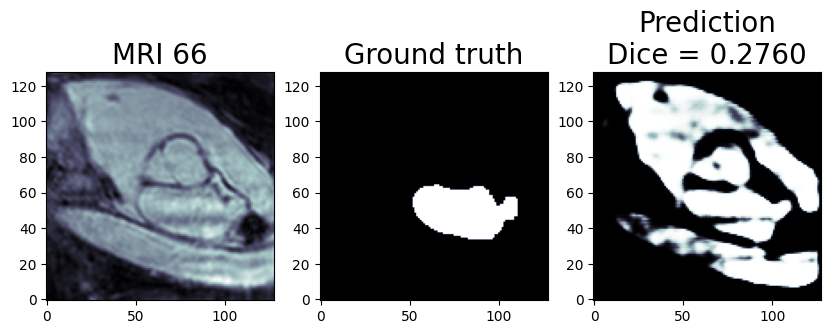

In [ ]:
plot_results(ds_test)

1/1 [==============================] - 0s 58ms/step
Elapsed time = 141.3970 msecs, Dice coefficient = 0.2760, 

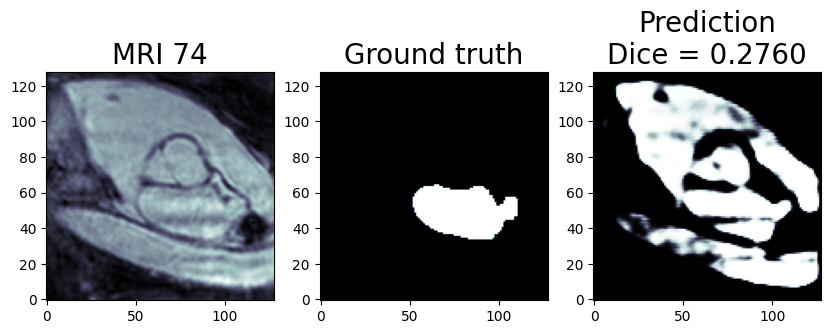

In [ ]:
plot_results(ds_test)